<a href="https://colab.research.google.com/github/Weifeng-Ke/Machine-Learning/blob/main/Programming_Assignment_3/CPEN455_2024W02_Assignment_3_Weifeng_Ke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment 2: Variational Autoencoder

**UBC CPEN 455: Deep Learning, 2024 Winter Term 2**

**Created By Qi Yan, Renjie Liao**

**Date: Mar. 20, 2025**

## Preface
In this assignment, you will implement a VAE model from scratch. A Colab notebook is provided with this documentation, which you need to complete. Please pay attention to the following notes:

* You are only required to modify and fill in the code inside the START/END blocks.
* For each module, one test case is provided. You may use the test cases to get a sense of how the input/output formats are, and as a sanity check for your implementation.
* Make sure your code is readable (by leaving comments and writing self-commented code).
* Unless otherwise specified, you are not allowed to use any module from `torch.distributions` module.
* All the code must be written by yourself, and you are not allowed to copy any code from other sources such as your classmates or the internet.
* If you use ChatGPT or other LLMs to help finish the assignment, please clearly mark which questions you use them. We may require you to submit your prompts. Please make sure you store them properly.
* Your code should support training on both CPU and CUDA devices, depending on availability (with CUDA prioritized). Not supporting GPU training will result in a loss of points.
* Very slow training will also lead to a loss of points. Your implementation should lead to efficient training that completes within 5 minutes; otherwise, you will lose points.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/CPEN_455/Assignment_3
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


## Setup

In [ ]:
# Imports
import torch
import random
import tarfile, requests, os

import numpy as np
import matplotlib.pylab as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from tqdm.notebook import tqdm, trange
import math

In [ ]:
def set_seed(seed=2025, mute=True):
  """
  Seet randomseed to control randomness.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  if not mute:
    print(f'Random seed {seed} has been set.')

def set_device():
  """
  Set the device on which to run PyTorch. CUDA if available, CPU otherwise
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, please enable GPU.")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED=2025
set_seed(seed=SEED, mute=False)
DEVICE = set_device()

Random seed 2025 has been set.
GPU is enabled in this notebook.


In [ ]:
!cd "/content/drive/MyDrive/CPEN_455/Assignment_3"
!pwd

/content


In [ ]:
# Download MNIST dataset
fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed!\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been downloaded.\n')

# Load MNIST image datasets
# See https://pytorch.org/docs/stable/torchvision/datasets.html
train_set = datasets.MNIST('./mnist/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False)
data_shape = (1, 28, 28)
data_size = 28 * 28

MNIST dataset has been downloaded.



In [ ]:
def plot_torch_image(image, ax=None):
  """
  Helper function to plot torch image
  @param image: torch.Tensor
  @param ax: plt object
  """
  ax = ax if ax is not None else plt.gca()
  c, h, w = image.size()
  if c==1:
    cm = 'gray'
  else:
    cm = None

  # [C, H, W] -> [H, W, C]
  im_plt = torch.clip(image.detach().cpu().permute(1,2,0).squeeze(), 0.0, 1.0)
  ax.imshow(im_plt, cmap=cm)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)


def plot_images(images, h=3, w=3, plt_title=''):
  """
  Helper function to plot images.
  @param images: torch.Tensor
  @param h: int, number of images in height direction
  @param w: int, number of images in width direction
  @param plt_title: string, Plot title
  """
  plt.figure(figsize=(h*2, w*2))
  plt.suptitle(plt_title)
  for i in range(h*w):
    plt.subplot(h, w, i + 1)
    plot_torch_image(images[i])

  plt.axis('off')
  plt.show()



## Implement a variational eutoendocer

The Variational Autoencoder (VAE) model defines a class of generative models based on latent space variables. In a VAE, we have an encoder that maps inputs $\mathbf{x}$ (e.g., image data) to entire distributions over hidden vectors $\mathbf{z}$, denoted by:

$$\mathbf{x} \overset{\text{VAE}}{\longrightarrow} q_{\mathbf{w_e}}(\mathbf{z})$$

We then sample from this distribution. Here, $\mathbf{w_e}$ refers to the weights of the encoder, which parameterize the distribution generating network. The specific form of the distribution $q_{\mathbf{w_e}}(\mathbf{z})$ is described in the following section.

In the decoder, reconstructions are expressed in terms of a distribution:

$$\mathbf{z} \overset{\text{VAE}}{\longrightarrow} p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})$$

As above, $p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})$ is defined by mapping $\mathbf{z}$ through a density network, and then treating the resulting $f(\mathbf{z};\mathbf{w_d})$ as the mean of a Gaussian distribution over $\mathbf{x}$. Similarly, the reconstruction distribution is parameterized by the weights of the density network.

To be specific, we use the evidence lower bound (ELBO) loss to train a VAE, which is composed of reconstruction loss and regularization loss:

$$\mathcal{L}_{\text{ELBO}} = -\mathbb{E}_{q(\mathbf{z} \mid \mathbf{x})} \left[\log p(\mathbf{x} \mid \mathbf{z}) \right] + \text{KL}\left(q(\mathbf{z} \mid \mathbf{x}) \| p(\mathbf{z}) \right)$$

Here, $q$ and $p$ are the encoder and decoder, respectively. We drop the subscripts $\mathbf{w_e}$ and $\mathbf{w_d}$ for brevity. The loss function of the VAE requires good reconstructions of the input not just for a single $\mathbf{z}$, but on average from samples of $\mathbf{z} \sim q_{\mathbf{w_e}}(\mathbf{z})$.

In the following sections, we will first implement each component of the ELBO loss, and then train and use VAEs to generate image samples.

## Q1.1 [5 Pts]: Implement Gaussian likelihood computation

In this task, we need to compute the log likelihood of the reconstructed data assuming a $k$-dimension isotropic Gaussian distribution with mean $\boldsymbol{\mu}$ and standard deviation $\sigma$.

The PDF of the isotropic Gaussian distribution is given by:

\begin{equation*}
p(\mathbf{x} \mid \boldsymbol{\mu},\sigma^2\mathbf{I}) = \frac{1}{(2\pi)^{k/2}\sigma^k} \exp\left(-\frac{1}{2\sigma^2}(\mathbf{x}-\boldsymbol{\mu})^\top(\mathbf{x}-\boldsymbol{\mu})\right)
\end{equation*}

where $\mathbf{x}$ is the observed sample.

Note that the isotropic Gaussian has a covariance matrix of the form $\Sigma = \sigma^2\mathbf{I}$, where $\mathbf{I}$ is the identity matrix of size $k$. This means that there is only one parameter governing the covariance matrix, which can be represented as $\sigma$. To ensure numerical stability, we usually parameterize the covariance using $\log \sigma$.

**Task**: Implement a function that takes the mean and standard deviation of the Gaussian distribution, along with the observed sample, and computes the log-likelihood of the sample.

I used chat for this part becase i was looking up how to do
\begin{equation*}
(\mathbf{x}-\boldsymbol{\mu})^\top(\mathbf{x}-\boldsymbol{\mu})
\end{equation*}

In [ ]:
def log_prob(x: torch.Tensor, mu: torch.Tensor, log_sigma: torch.Tensor) -> torch.Tensor:
  """
  ### Fill in this function ###
  Compute element-wise log Gaussian probability.
  @param x:          [B, N, K]: input data (observations of Gaussian distribution), there are N samples for each of the B batches, each sample has K dimensions.
  @param mu:         [B, N, K]: mean of Gaussian distribution.
  @param log_sigma:  [B, N]: log of standard deviation of Gaussian distribution.
  @return log_prob:  [B, N]: log Gaussian probability for each sample in the batch.
  """
  ### START CODE HERE ###
  #get the dimension of each sample
  B,N,K=x.shape;

  #compute the sigma_square from log of sigma; e^(2log(sigma))=sigma^2
  sigma_square=torch.exp(2*log_sigma);

  #compute what's in the bracket (x-u)^T * (x-u) = sum from i=1 to K (xi-ui)^2
  square_error = torch.sum((x-mu) ** 2, dim=-1);

  #print(square_error.shape)

  #compute the log of gaussian probability
  #after taking the log of the above equation it ended up to be 0-k/2 * ln(2pi)-k*ln(sigma) -1/2sigma^2 (x-u)^T(x-u)
  log_prob= -0.5 * K * math.log(2*math.pi) - K * log_sigma - (square_error / (2 * sigma_square));

  ### END CODE HERE ###
  return log_prob


def gt_log_prob(x: torch.Tensor, mu: torch.Tensor, log_sigma: torch.Tensor) -> torch.Tensor:
  """
  Ground truth function used for unit test. Do not modify.
  @param x:          [B, N, K]: input data (observations of Gaussian distribution), there are N samples for each of the B batches, each sample has K dimensions.
  @param mu:         [B, N, K]: mean of Gaussian distribution.
  @param log_sigma:  [B, N]: log of standard deviation of Gaussian distribution.
  @return log_prob:  [B, N]: log Gaussian probability for each sample in the batch.
  """
  gt_log_prob = torch.distributions.normal.Normal(mu, log_sigma[:, :, None].exp()).log_prob(x)
  gt_log_prob = gt_log_prob.sum(dim=-1)
  return gt_log_prob


def unit_test_log_prob(func_log_prob=log_prob, func_gt_log_prob=gt_log_prob):
  """
  Unit test helper. Do not modify.
  """
  b, n = torch.randint(1, 32, [2])
  k = torch.randint(1, 8, [1])
  x = torch.randn([b, n, k])
  mu = torch.randn([b, n, k])
  log_sigma = torch.rand([b, n])

  true_log_prob = func_gt_log_prob(x, mu, log_sigma)                  # [B, N]
  compute_log_prob = func_log_prob(x, mu, log_sigma)                  # [B, N]
  error = (true_log_prob - compute_log_prob).square().mean().sqrt()   # scalar

  if error < 1e-5:
    print("Your implementation is correct.")
  else:
    print("Your implementation is incorrect.")


set_seed(seed=SEED)
unit_test_log_prob()

Your implementation is correct.


## Q1.2 [5 Pts]: Implement Monte-Carlo Approximation of KL Divergence

The KL divergence between two distributions $q$ and $p$ is defined as:

\begin{equation*}
KL(q \parallel p) = \int q(x)\log \frac{q(x)}{p(x)} = \mathbb{E}_{x\sim q}\left[\log \frac{q(x)}{p(x)} \right] = \mathbb{E}_{x\sim q}\left[ \log q(x) - \log p(x) \right]
\end{equation*}

In practice, we can approximate it using Monte Carlo estimation. Suppose we have two sets of $N$ i.i.d. samples $x=\{x^{(1)}, x^{(2)}, \cdots, x^{(N)}\}$ from the $q$ distribution, and we can compute their probability densities under $q$ and $p$. Then, we can estimate the rightmost expectation term with:

\begin{equation*}
KL(q \parallel p) \approx \frac{1}{N}\sum_{i=1}^N\left(\log q(x^{(i)}) - \log p(x^{(i)})\right)
\end{equation*}

Please refer to http://joschu.net/blog/kl-approx.html for more information.

**Task**: Assume $q$ and $p$ are multivariate Gaussian distributions with isotropic covariance matrix (as in Q1.1). Given samples from $q$ distributions, and the mean and standard deviation of $q$ and $p$, compute the KL divergence using Monte Carlo estimation.


In [ ]:
def kl_q_p_mc(samples_q: torch.Tensor, params_q: torch.Tensor, params_p: torch.Tensor) -> torch.Tensor:
  """
  ### Fill in this function ###
  Compute the KL divergence between the q distirubtion and p distribution using Monte-Carlo approximation.
  Hints: you could reuse the above log_prob function.
  @param samples_q: [B, N, K]: samples from B many q distributions, there are N samples in each batch, each of them has K dimensions
  @param params_q: [B, K+1]: parameters of B many q distribution, the first K elements are the mean, the last element is the log standard deviation
  @param params_p: [B, K+1]: parameters of B many p distribution, the first K elements are the mean, the last element is the log standard deviation
  @return kl_q_p_mc [B]: KL(q||p) for q||p
  """
  # Init
  b, n, k = samples_q.size()
  mu_q, log_sig_q = params_q[:, :-1], params_q[:, -1]  # [B, K], [B]
  mu_p, log_sig_p = params_p[:, :-1], params_p[:, -1]  # [B, K], [B]

  ### START CODE HERE ###
  # Compute the log probabilities under q and p distributions.
  # unsqueeze to add the sample dimension (N) for broadcasting.
  log_q = log_prob(samples_q, mu_q.unsqueeze(1), log_sig_q.unsqueeze(1).expand(b, n))
  log_p = log_prob(samples_q, mu_p.unsqueeze(1), log_sig_p.unsqueeze(1).expand(b, n))
  #use monte carlos approximation once we have log q and log p we can just do the average
  kl_mc = (log_q - log_p).mean(dim=1)
  ### END CODE HERE ###
  return kl_mc


def gt_kl_q_p_mc(samples_q: torch.Tensor, params_q: torch.Tensor, params_p: torch.Tensor) -> torch.Tensor:
  """
  Ground truth function used for unit test. Do not modify.
  @param samples_q: [B, N, K]: samples from B many q distributions, there are N samples in each batch, each of them has K dimensions
  @param params_q: [B, K+1]: parameters of B many q distribution, the first K elements are the mean, the last element is the log standard deviation
  @param params_p: [B, K+1]: parameters of B many p distribution, the first K elements are the mean, the last element is the log standard deviation
  @return kl_q_p_mc [B]: KL(q||p) for q||p
  """
  # Init
  b, n, k = samples_q.size()
  mu_q, log_sig_q = params_q[:, :-1], params_q[:, -1]  # [B, K], [B]
  mu_p, log_sig_p = params_p[:, :-1], params_p[:, -1]  # [B, K], [B]
  sigma_q, sigma_p = log_sig_q.exp(), log_sig_p.exp()  # [B], [B]

  gt_log_prob_q = torch.distributions.normal.Normal(mu_q.unsqueeze(1), sigma_q[:, None, None]).log_prob(samples_q)  # [B, N, K]
  gt_log_prob_q = gt_log_prob_q.sum(dim=-1)  # [B]
  gt_log_prob_p = torch.distributions.normal.Normal(mu_p.unsqueeze(1), sigma_p[:, None, None]).log_prob(samples_q)  # [B, N, K]
  gt_log_prob_p = gt_log_prob_p.sum(dim=-1)  # [B]
  return (gt_log_prob_q - gt_log_prob_p).mean(dim=1)  # [B]


def unit_test_kl_q_p_mc(func_kl_q_p_mc=kl_q_p_mc, func_gt_kl_q_p_mc=gt_kl_q_p_mc):
  """
  Unit test helper. Do not modify.
  """
  b, n = torch.randint(1, 32, [2])
  k = torch.randint(1, 8, [1])
  x_q = torch.randn([b, n, k])
  mu_q = torch.randn([b, k])
  log_sigma_q = torch.rand([b])

  mu_p = torch.randn([b, k])
  log_sigma_p = torch.rand([b])

  params_q = torch.cat([mu_q, log_sigma_q[:, None]], dim=-1)            # K means + 1 log sigma
  params_p = torch.cat([mu_p, log_sigma_p[:, None]], dim=-1)            # K means + 1 log sigma

  true_kl_q_p_mc =  func_gt_kl_q_p_mc(x_q, params_q, params_p)     # [B]
  compute_kl_q_p_mc = func_kl_q_p_mc(x_q, params_q, params_p)      # [B]
  error = (true_kl_q_p_mc - compute_kl_q_p_mc).square().mean().sqrt()   # scalar
  if error < 1e-5:
    print("Your implementation is correct.")
  else:
    print("Your implementation is incorrect.")


set_seed(seed=SEED)
unit_test_kl_q_p_mc()

Your implementation is correct.


## Q1.3 [5 Pts]: Implement exact KL divergence
In Q1.2, we assumed a simple case where both the $q$ and $p$ distributions were Gaussian and their parameters were known. More precisely, we could evaluate the exact KL divergence between them using the following formula:

\begin{equation*}
KL(\mathcal{N}_q\parallel\mathcal{N}_p) = \frac{1}{2}\left(k \left(\frac{\sigma_q}{\sigma_p}\right)^2 + (\boldsymbol{\mu}_q - \boldsymbol{\mu}_p)^\top \frac{1}{\sigma_p^2} (\boldsymbol{\mu}_q - \boldsymbol{\mu}_p) - k + 2 k \log\frac{\sigma_p}{\sigma_q}\right)
\end{equation*}

For more information about the derivation, see this [reference](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/).

**Task**: Assuming that $q$ and $p$ are multivariate Gaussian distributions with isotropic covariance matrices (as in Q1.1), and given the mean and standard deviation of $q$ and $p$, compute the exact KL divergence.

I have used to chat to check if my KL calculation matches the KL divergence formula

In [ ]:
def kl_q_p_exact(params_q: torch.Tensor, params_p: torch.Tensor) -> torch.Tensor:
  """
  ### Fill in this function ###
  Compute the exact KL divergence between the q distirubtion and p distribution.
  Hints: you could reuse the above log_prob function.
  @param params_q: [B, K+1]: parameters of B many q distribution, the first K elements are the mean, the last element is the log standard deviation
  @param params_p: [B, K+1]: parameters of B many p distribution, the first K elements are the mean, the last element is the log standard deviation
  @return kl_q_p_e [B]: KL(q||p) for q||p
  """
  # Init
  b, k_ = params_q.shape
  k = k_ - 1
  mu_q, log_sig_q = params_q[:, :-1], params_q[:, -1]  # [B, K], [B]
  mu_p, log_sig_p = params_p[:, :-1], params_p[:, -1]  # [B, K], [B]

  ### START CODE HERE ###
  # Compute the sigma from log_sigma.
  sigma_q = torch.exp(log_sig_q)
  sigma_p = torch.exp(log_sig_p)

  #conpute the mu difference
  mu_diff_square = ((mu_q - mu_p) **2).sum(dim=1)

  #compute the kl divergence
  kl = 0.5 * (k * (sigma_q / sigma_p) ** 2 + mu_diff_square / (sigma_p ** 2) - k + 2 * k * torch.log(sigma_p / sigma_q));

  ### END CODE HERE ###

  return kl


def gt_kl_q_p_exact(params_q: torch.Tensor, params_p: torch.Tensor) -> torch.Tensor:
  """
  Ground truth function used for unit test. Do not modify.
  @param params_q: [B, K+1]: parameters of B many q distribution, the first K elements are the mean, the last element is the log standard deviation
  @param params_p: [B, K+1]: parameters of B many p distribution, the first K elements are the mean, the last element is the log standard deviation
  @return kl_q_p_e [B]: KL(q||p) for q||p
  """
  # Init
  mu_q, log_sig_q = params_q[:, :-1], params_q[:, -1]  # [B, K], [B]
  mu_p, log_sig_p = params_p[:, :-1], params_p[:, -1]  # [B, K], [B]

  gt_log_prob_q = torch.distributions.normal.Normal(mu_q, log_sig_q[:, None].exp())
  gt_log_prob_p = torch.distributions.normal.Normal(mu_p, log_sig_p[:, None].exp())
  gt_kl_q_p_exact = torch.distributions.kl.kl_divergence(gt_log_prob_q, gt_log_prob_p).sum(dim=-1)  # [B] <- [B, K]
  return gt_kl_q_p_exact  # [B]


def unit_test_kl_q_p_exact(func_kl_q_p_exact=kl_q_p_exact, func_gt_kl_q_p_exact=gt_kl_q_p_exact):
  """
  Unit test helper. Do not modify.
  """
  b = torch.randint(1, 32, [1])
  k = torch.randint(1, 8, [1])
  mu_q = torch.randn([b, k])
  log_sigma_q = torch.rand([b])
  mu_p = torch.randn([b, k])
  log_sigma_p = torch.rand([b])

  params_q = torch.cat([mu_q, log_sigma_q[:, None]], dim=-1)
  params_p = torch.cat([mu_p, log_sigma_p[:, None]], dim=-1)

  compute_kl_q_p_exact = func_kl_q_p_exact(params_q, params_p)  # [B]
  true_kl_q_p_exact = func_gt_kl_q_p_exact(params_q, params_p)  # [B]

  error = (true_kl_q_p_exact - compute_kl_q_p_exact).square().mean().sqrt()  # scalar
  if error < 1e-5:
    print("Your implementation is correct.")
  else:
    print("Your implementation is incorrect.")


set_seed(seed=SEED)
unit_test_kl_q_p_exact()

Your implementation is correct.


### Compare Monte-Carlo Approximation and Exact KL Divergence

*Note: No implementation is required.*

In Q1.2 and Q1.3, we have implemented two methods to estimate the KL divergence between two distributions. The Monte-Carlo estimation method provides an approximation to the KL divergence by drawing samples from the $q$ distributions. On the other hand, the exact KL divergence formula can be used when the two distributions are known.

In practice, we can compare the two methods to see how well the Monte-Carlo approximation performs. When a sufficient number of samples are used, the Monte-Carlo method can yield results that are close to the exact KL divergence.

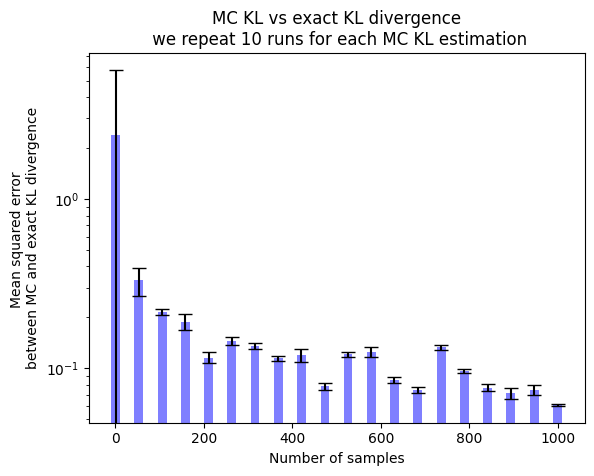

In [ ]:
def compare_exact_mc_kl(func_gt_kl_q_p_exact=gt_kl_q_p_exact, func_gt_kl_q_p_mc=gt_kl_q_p_mc):
    """
    Unit test helper. Do not modify.
    """
    b, k = 1, 4
    mu_q = torch.zeros([b, k])
    log_sigma_q = torch.zeros([b])
    mu_p = torch.ones([b, k]) * 10.0
    log_sigma_p = torch.ones([b])

    params_q = torch.cat([mu_q, log_sigma_q[:, None]], dim=-1)
    params_p = torch.cat([mu_p, log_sigma_p[:, None]], dim=-1)

    true_kl_q_p_exact = func_gt_kl_q_p_exact(params_q, params_p)  # [B]

    num_samples = torch.linspace(1, 1000, 20).clamp(min=1.0).long()
    num_repeat = 10

    diff_ls, var_ls = [], []
    for n in num_samples:
        this_diff = []
        for r in range(num_repeat):
            x_q = torch.distributions.normal.Normal(mu_q, log_sigma_q[:, None].exp()).sample([n])  # [N, B, K]
            x_q = x_q.permute(1, 0, 2)  # [B, N, K]
            true_gt_kl_q_p_mc = func_gt_kl_q_p_mc(x_q, params_q, params_p)  # [B]

            this_diff.append((true_kl_q_p_exact - true_gt_kl_q_p_mc).norm(p=2).item())  # scalar

        diff_ls.append(np.mean(this_diff))  # scalar
        var_ls.append(np.var(this_diff))  # scalar

    fig = plt.figure()
    ax = fig.gca()
    # ax.scatter(num_samples.numpy(), diff_ls)
    ax.bar(num_samples.numpy(), diff_ls, width=20.0, yerr=var_ls, capsize=5.0, color='blue', alpha=0.5)
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("Mean squared error \nbetween MC and exact KL divergence")
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("MC KL vs exact KL divergence\n we repeat 10 runs for each MC KL estimation")

    # print(diff_ls)

    plt.show()

set_seed(seed=SEED)
compare_exact_mc_kl()


## Q1.4 [5 Pts]: Implement reparameterization trick for sampling

The reparameterization trick is a method that allows us to sample from a distribution in a way that makes backpropagation of gradients through the sampling operation possible. The basic idea is to transform the random variable to be sampled into a function of a random variable with fixed distribution, and then sample from the fixed distribution. For example, we can use this trick to get samples from a Gaussian distribution without "directly drawing samples" from it.

Suppose we want to sample from a $k$-dimensional Gaussian distribution with isotropic covariance matrix. Let $\boldsymbol{\mu} \in \mathbb{R}^k$ and $\sigma \in \mathbb{R}$ be the mean and standard deviation of the distribution, respectively. We can reparameterize a random variable $\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$ as $\boldsymbol{x} = \boldsymbol{\mu} + \sigma\boldsymbol{z}$ to obtain a sample from the Gaussian distribution. Here, $\boldsymbol{z}$ is a $k$-dimensional vector of independent standard normal random variables, and $\boldsymbol{I}$ is the $k \times k$ identity matrix. During sampling, we first get samples from $\boldsymbol{z}$, and transform them linearly to get samples from $\boldsymbol{x}$.

**Task**: Given the mean and standard deviation of a $k$-dimension Gaussian distribution with isotropic covariance matrix, implement the reparameterization trick to draw samples from this distribution.

I have asked the chat to see if my implementation fo the treparametrization trick is correct or not because the unit test saying my implementation is likely wrong

Your implementation is likely correct.


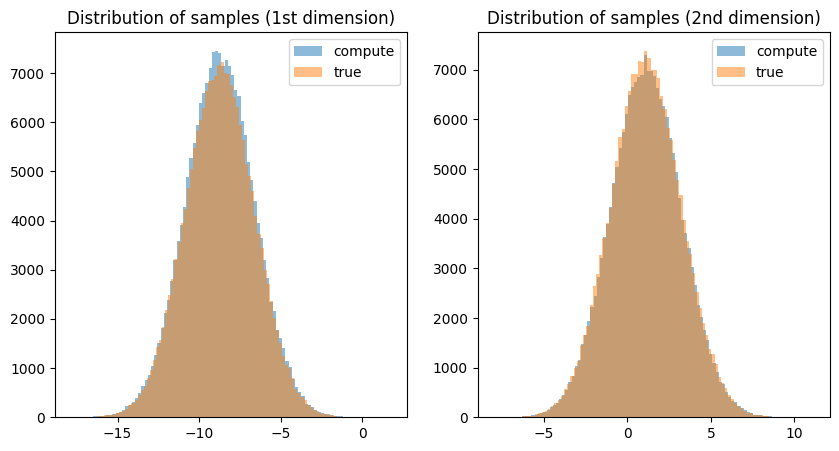

In [ ]:
def rsample(params_q: torch.Tensor, num_samples: int) -> torch.Tensor:
    """
    ### Fill in this function ###
    Obtain samples from Gaussian distributions, provided the mean and covariance parameters.
    @param params_q:        [B, K+1]: parameters of B many q distribution, the first K elements are the mean, the last element is the log standard deviation
    @param num_samples:     int: number of samples to create
    @return x_q:            [B, N, K]: samples from q distribution, where N is the number of samples
    """

    # Init
    b, k_ = params_q.shape
    k = k_ - 1
    mu_q, log_sig_q = params_q[:, :-1], params_q[:, -1]  # [B, K], [B]

    ### START CODE HERE ###
    #find the sigma
    sigma = torch.exp(log_sig_q);

    #comput the epsilon
    epsilon = torch.randn(b,num_samples,k,device=params_q.device, dtype=params_q.dtype);

    #the trick is x=mu+ sigma *epsilon
    #x_q=mu_q+ sigma * epsilon;
    x_q = mu_q.unsqueeze(1) + sigma.unsqueeze(1).unsqueeze(2) * epsilon

    ### END CODE HERE ###

    return x_q


def gt_rsample(params_q: torch.Tensor, num_samples: int) -> torch.Tensor:
    """
    Ground truth implementation of rsample. Do not modify.
    @param params_q:        [B, K+1]: parameters of B many q distribution, the first K elements are the mean, the last element is the log standard deviation
    @param num_samples:     int: number of samples to create
    @return x_q:            [B, N, K]: samples from q distribution, where N is the number of samples
    """
    # Init
    b, k_ = params_q.shape
    k = k_ - 1
    mu_q, log_sig_q = params_q[:, :-1], params_q[:, -1]  # [B, K], [B]

    x_q = torch.distributions.normal.Normal(mu_q, log_sig_q[:, None].exp()).sample([num_samples])  # [N, B, K]
    x_q = x_q.permute(1, 0, 2)  # [B, N, K]
    return x_q


def unit_test_rsample(func_rsample=rsample, func_gt_rsample=gt_rsample):
    """
    Unit test helper. Do not modify.
    """
    b, k = 1, 2
    mu_q = torch.randn([b, k]) * 10.0
    log_sigma_q = torch.rand([b])

    params_q = torch.cat([mu_q, log_sigma_q[:, None]], dim=-1)

    num_samples = 200000

    compute_x_q = func_rsample(params_q, num_samples)            # [B, N, K]
    true_x_q = func_gt_rsample(params_q, num_samples)            # [B, N, K]

    mean_error = (compute_x_q.mean(dim=1) - true_x_q.mean(dim=1)).mean(dim=-1)  # [B]
    std_error = (compute_x_q.std(dim=1, unbiased=False) - true_x_q.std(dim=1, unbiased=False)).mean(dim=-1)  # [B]
    error = mean_error.abs().mean().item() + std_error.abs().mean().item()
    if error < 1e-2:
        print("Your implementation is likely correct.")
    else:
        print("Your implementation is likely incorrect.")

    # visualize the distribution
    figs, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(compute_x_q[0, :, 0].numpy(), bins=100, alpha=0.5, label='compute')
    axs[0].hist(true_x_q[0, :, 0].numpy(), bins=100, alpha=0.5, label='true')
    axs[0].legend()
    axs[0].set_title("Distribution of samples (1st dimension)")

    axs[1].hist(compute_x_q[0, :, 1].numpy(), bins=100, alpha=0.5, label='compute')
    axs[1].hist(true_x_q[0, :, 1].numpy(), bins=100, alpha=0.5, label='true')
    axs[1].legend()
    axs[1].set_title("Distribution of samples (2nd dimension)")


set_seed(seed=SEED)
unit_test_rsample()

## Q1.5 [5 Pts]: Implement ELBO loss

Recall that the ELBO loss reads as follows:

$$\mathcal{L}_{\text{ELBO}} = -\mathbb{E}_{q(\mathbf{z} \mid \mathbf{x})} \left[\log p(\mathbf{x} \mid \mathbf{z}) \right] + \text{KL}\left(q(\mathbf{z} \mid \mathbf{x}) \| p(\mathbf{z}) \right),$$

where $\mathbf{x}$ is the observable data, $\mathbf{z}$ is the latent variable, and $q$ and $p$ are the encoder and decoder respectively.

To compute the full ELBO loss for a simple case where the encoder $q(\mathbf{z} \mid \mathbf{x})$ and decoder $p(\mathbf{x} \mid \mathbf{z})$ are parameterized by Gaussians with known parameters, and $p(\mathbf{z})$ is the standard normal distribution, we can follow these steps:

* Draw $N$ samples from $q(\mathbf{z} \mid \mathbf{x})$ using the reparameterization trick, where $N$ is the number of samples.

* Pass the samples through the decoder $p(\mathbf{x} \mid \mathbf{z})$ to obtain reconstructions.

* Compute the log-likelihood of the reconstructions under $p(\mathbf{x} \mid \mathbf{z})$.

* Average the log-likelihood over the $N$ samples to obtain an unbiased estimate of $-\mathbb{E}_{q(\mathbf{z} \mid \mathbf{x})} \left[\log p(\mathbf{x} \mid \mathbf{z}) \right]$.

* Compute the exact KL divergence $\text{KL}\left(q(\mathbf{z} \mid \mathbf{x}) \| p(\mathbf{z}) \right)$ to obtain the full ELBO Loss.

**Task**: given $q(\mathbf{z} \mid \mathbf{x})$ and $p(\mathbf{x} \mid \mathbf{z})$ parameterized by Gaussians, compute the full ELBO loss.


The steps are really helpful but i have to watch a few youtube videos to figure out how to do the last part to compute the KL divergence

In [ ]:
def elbo(x: torch.Tensor, params_q: torch.Tensor, num_samples: int, func_decoder, log_sig_x: float) -> torch.Tensor:
    """
    ### Fill in this function ###
    Obtain samples from Gaussian distributions, provided the mean and covariance parameters.
    @param x:               [B, D]: observable data
    @param params_q:        [B, K+1]: parameters of B many q distribution, the first K elements are the mean, the last element is the log standard deviation
    @param num_samples:     int: N, number of samples to create
    @param func_decoder:    function: decoder function, takes in [B, N, K] and returns [B, N, D]
    @return elbo:           [B]: elbo for each data point
    """
    # note: to pass through decoder, one can use mu_x = func_decoder(z_q)  # mu_x: [B, N, D] <- z_q: [B, N, K]
    # note: the gt_rsample function is provided for you for unit testing
    z_q = gt_rsample(params_q, num_samples)  # [B, N, K], z samples

    ### START CODE HERE ###
    #passs the sample through the decoder to obtain the reconstruction
    mu_x= func_decoder(z_q);

    #make x from [B,D] -> [B,N,D]
    x=x.unsqueeze(1).expand(-1,num_samples,-1);

    log_sig_x_tensor=torch.tensor(log_sig_x,dtype=torch.float32,device=x.device);
    #compute the log likelihopd of the reconstruction under p(x|z)
    recon_log_prob=log_prob(x,mu_x,log_sig_x_tensor);
    #take an averge of the log-likelihood over the N samples to obtain an unbiased estimate of -E_{q(z|x)}[log p(x|z)]
    avg_recon_log_prob=recon_log_prob.mean(dim=1);

    std_norm_params = torch.zeros_like(params_q)  # [B, K+1]
    kl_q_p = kl_q_p_exact(params_q, std_norm_params)  # [B]
    elbo = -avg_recon_log_prob + kl_q_p  # [B]
    ### END CODE HERE ###

    return elbo


def gt_elbo(x: torch.Tensor, params_q: torch.Tensor, num_samples: int, func_decoder, log_sig_x: float) -> torch.Tensor:
    """
    Ground truth ELBO function. Do not modify.
    @param x:               [B, D]: observable data
    @param params_q:        [B, K+1]: parameters of B many q distribution, the first K elements are the mean, the last element is the log standard deviation
    @param num_samples:     int: N, number of samples to create
    @param func_decoder:    function: decoder function, takes in [B, N, K] and returns [B, N, D]
    @return elbo:           [B]: elbo for each data point
    """
    z_q = gt_rsample(params_q, num_samples)  # [B, N, K], z samples
    mu_x = func_decoder(z_q)  # [B, N, D] <- [B, N, K]

    log_sig_x = torch.tensor(log_sig_x, dtype=torch.float32, device=x.device)  # [1]
    log_sig_x = log_sig_x.view(1, 1).expand(mu_x.shape[0], mu_x.shape[1])  # [B, N]
    log_prob_x = gt_log_prob(x[:, None, :].expand(-1, num_samples, -1), mu_x, log_sig_x).mean(dim=-1)  # [B] <- [B, N]

    params_std_norm = torch.zeros_like(params_q)  # [B, K+1]
    kl_q_p = gt_kl_q_p_exact(params_q, params_std_norm)  # [B]
    elbo = -log_prob_x + kl_q_p  # [B]

    return elbo

def unit_test_elbo(func_elbo=elbo, func_gt_elbo=gt_elbo):
    """
    Unit test helper. Do not modify.
    """
    b, k, n, d = 10, 1, 1, 64
    mu_q = torch.randn([b, k])
    log_sigma_q = torch.rand([b])

    x = torch.randn([b, d])  # [B, N, D]
    params_q = torch.cat([mu_q, log_sigma_q[:, None]], dim=-1)  # [B, K+1]

    # func_decoder = lambda x: x * 0.5 + 1.0  # [B, N, K] -> [B, N, D]
    func_decoder = nn.Linear(k, d, bias=True)
    log_sig_x = torch.rand([1]).item()

    set_seed(seed=SEED)
    comp_elbo = func_elbo(x, params_q, n, func_decoder, log_sig_x)

    set_seed(seed=SEED)
    true_elbo = func_gt_elbo(x, params_q, n, func_decoder, log_sig_x)

    error = torch.abs(comp_elbo - true_elbo).mean()
    print("Error: ", error.item())
    if error < 1e-5:
        print("Your implementation is correct.")
    else:
        print("Your implementation is incorrect.")


set_seed(seed=SEED)
unit_test_elbo()

Error:  7.62939453125e-06
Your implementation is correct.


## Q2.1 [10 Pts]: Build and train the VAE model

Now that we have implemented the necessary functions in Q1, we can use them to build a simple VAE and begin training.

**Task**: in this part, you are given the full code for the VAE model.
We need to re-use and properly adapt the previously implemented `rsample`, `log_prob`, and `kl_q_p_exact` functions for training purposes.
If your functions passed the previous unit tests, they should be ready to use.

You should be able to observe a rising trend in the ELBO training curve. We require you to implement efficient training that completes within 5 minutes on a GPU (e.g., a T4 available in Google Colab); otherwise, you will lose points.

Note: if you can't pass Q2.1, you can still proceed to Q2.2.

In [ ]:
class SimpleVAE(nn.Module):
  """
  Simple VAE with convolutional encoder and decoder.
  """
  def __init__(self, K=2, num_filters=32):
    """
    We aim to build a simple VAE with the following architecture for the MNIST dataset.
    @param K: int: Bottleneck dimensionality
    @param num_filters: int: Number of filters [default: 32]
    """

    super(SimpleVAE, self).__init__()

    self.kernel_size = 5  # fixed
    self.image_size = 28  # fixed
    self.size_after_conv = self.image_size - 2 * 2 * (self.kernel_size // 2)
    self.flat_size_after_conv = self.size_after_conv * self.size_after_conv * num_filters

    # encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, num_filters, self.kernel_size),
        nn.ReLU(),
        nn.Conv2d(num_filters, num_filters, self.kernel_size),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(self.flat_size_after_conv, K+1)
    )

    # decoder
    self.decoder = nn.Sequential(
        nn.Linear(K, self.flat_size_after_conv),
        nn.Unflatten(1, (num_filters, self.size_after_conv, self.size_after_conv)),
        nn.ReLU(),
        nn.ConvTranspose2d(num_filters, num_filters, self.kernel_size),
        nn.ReLU(),
        nn.ConvTranspose2d(num_filters, 1, self.kernel_size),
    )

    # decoder variance parameter: for simplicity, we define a scalar log_sig_x for all pixels
    self.log_sig_x = nn.Parameter(torch.zeros(()))

  def decode(self, samples_z):
    """
    Wrapper for decoder
    @param samples_z:   [B, N, K]: samples from the latent space, B: batch size, N: number of samples, K: latent dimensionality
    @return mu_xs:      [B, N, C, H, W]: mean of the reconstructed data, B: batch size, N: number of samples, D: data dimensionality
    """
    b, n, k = samples_z.shape
    s_z = samples_z.view(b * n, -1)                                     # [B*N, K]
    s_z = self.decoder(s_z)                                             # [B*N, D]
    mu_xs = s_z.view(b, n, 1, self.image_size, self.image_size)         # [B, N, C, H, W]
    return mu_xs

  def elbo(self, x, n=1):
    """
    Run input end to end through the VAE and compute the ELBO using n samples of z
    @param x:       [B, C, H, W]: input image, B: batch size, C: number of channels, H: height, W: width
    @param n:       int: number of samples of z sample and reconstruction samples
    @return elbo:   scalar: aggregated ELBO loss for each image in the batch
    """
    phi = self.encoder(x)     # [B, K+1] <- [B, C, H, W]
    zs = rsample(phi, n)      # [B, N, K] <- [B, K+1]
    mu_xs = self.decode(zs)   # [B, N, C, H, W] <- [B, N, K]

    b, c, h, w = x.shape
    x_flat = x.view(b, 1, -1).expand(-1, n, -1)                 # [B, N, C*H*W] <- [B, 1, C*H*W] <- [B, C, H, W]
    mu_xs_flat = mu_xs.view(b, n, -1)                           # [B, N, C*H*W]
    log_sig_x = self.log_sig_x.view(1, 1).expand(x.size(0), n)  # [B, N]

    # note: we use the exact KL divergence here, but we could also use the Monte Carlo approximation
    # note: we didn't use the ELBO loss implemented in Q1.5, because it is less numerically stable
    elbo_loss = log_prob(x_flat, mu_xs_flat, log_sig_x).mean() - kl_q_p_exact(phi, torch.zeros_like(phi)).mean()
    return elbo_loss


K_VAE = 2
vae = SimpleVAE(K=K_VAE)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

Learned sigma_x is 0.2035788744688034


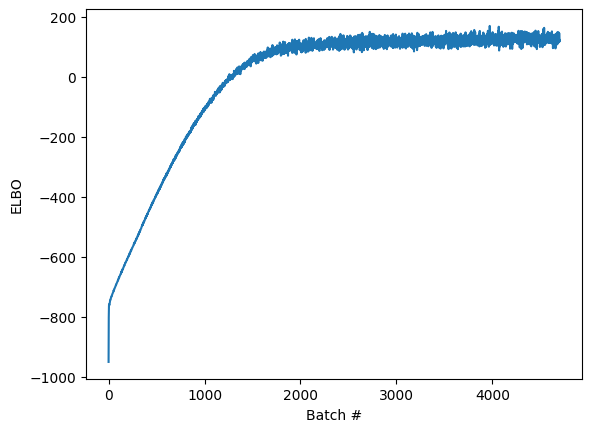

In [ ]:
def train_vae(model, dataset, epochs=10, n_samples=1000, batch_size=128):
  """
  VAE trainer.
  """
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
  model.to(DEVICE)
  model.train()
  elbo_vals = []
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  for epoch in trange(epochs, desc='Epochs'):
    pbar = tqdm(loader, total=len(dataset) // batch_size, desc='Batches', leave=False)
    for im, _ in pbar:
      im = im.to(DEVICE)

      optimizer.zero_grad(set_to_none=True)
      loss = -model.elbo(im, n=n_samples)
      loss.backward()
      optimizer.step()

      elbo_vals.append(-loss.item())

      pbar.set_description('Batches avg ELBO: {:.2f}'.format(np.mean(elbo_vals)))
  model.to('cpu')
  model.eval()
  return elbo_vals


# Train the VAE
elbo_vals = train_vae(vae, train_set, epochs=20, n_samples=10, batch_size=256)
print("Learned sigma_x is {}".format(torch.exp(vae.log_sig_x)))

# Plot ELBO training curve
plt.figure()
plt.plot(elbo_vals)
plt.xlabel('Batch #')
plt.ylabel('ELBO')
plt.show()

## Q2.2 [5 Pts]: Generate new samples using trained VAE model
Now we can generate new samples using the VAE model that we trained. Recall that the decoder is responsible for generating reconstructions:

$$\mathbf{z} \overset{\text{VAE}}{\longrightarrow} p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})$$

During training, $\mathbf{z} \sim q(\mathbf{z} \mid \mathbf{x})$ is sampled from a distribution given by the encoder. The encoder takes observable data $\mathbf{x}$ as input.

During inference, we no longer have access to $\mathbf{x}$, and instead we sample $\mathbf{z} \sim q(\mathbf{z})$ from its prior distribution, which is standard normal.

To generate new images, we pass the $\mathbf{z}$ samples to the decoder $p(\mathbf{x}|\mathbf{z})$ and obtain the mean of the reconstruction, which serves as our samples.

**Task**: use the VAE model's `decode` method to create new samples, given a pretrained model's weight.

Note: you don't need functions from Q1 or Q2.1.

In [ ]:
!cd /content/drive/MyDrive/CPEN_455/Assignment_3
# download vae unit test file
!gdown 1bRN-alJ8Ayidu3tprf876FhAcDjGa70a -q -O cpen455_24w2_vae_unit_test.pt

Your implementation is correct.
See below visualizations as a sanity check. (The images should look exactly the same.)


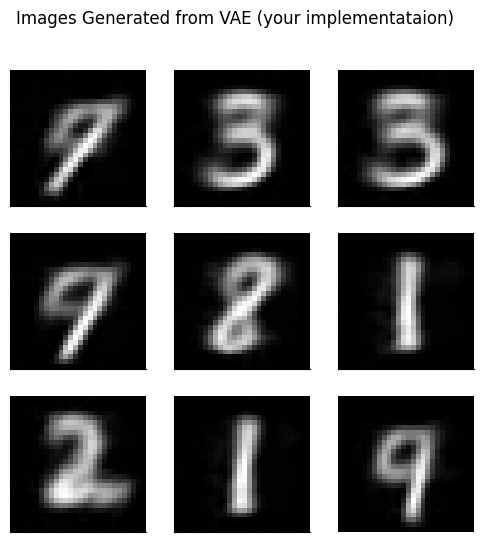

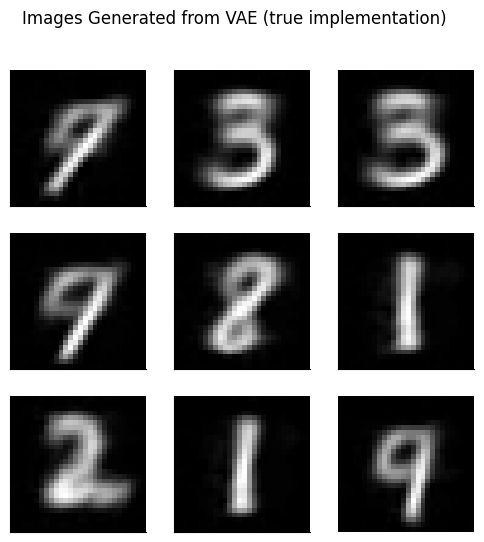

In [ ]:
def generate_images(vae, K=2, n_images=9):
  """
  ### Fill in this function ###
  Generate new images from the given VAE. Sample z from a unit gaussian, pass through autoencoder.decode()
  @param vae:       VAE model
  @param K:         int: latent dimensionality
  @param n_images:  int: number of images to generate
  """
  # Init
  output_shape = (n_images,) + data_shape   # [X, C, H, W] = [X, 1, 28, 28] for MNIST
  samples_z = torch.randn(n_images, 1, K)   # [X, 1, K]

  with torch.no_grad():
    ### START CODE HERE ###
    samples_x = vae.decode(samples_z);

    samples_x=samples_x.squeeze(K);
    ### END CODE HERE ###
    return samples_x


def unit_test_generate_images(vae=vae):
  vae_unit_test_data = torch.load('cpen455_24w2_vae_unit_test.pt')
  vae.load_state_dict(vae_unit_test_data['model'])
  vae.eval()
  vae = vae.to('cpu')
  img_samples = vae_unit_test_data['samples']
  images = generate_images(vae, K_VAE, n_images=9)

  error = torch.abs(images - img_samples).mean()
  if error < 1e-5:
    print("Your implementation is correct.")
  else:
    print("Your implementation is incorrect.")

  print("See below visualizations as a sanity check. (The images should look exactly the same.)")

  plot_images(images, plt_title='Images Generated from VAE (your implementataion)')
  plot_images(img_samples, plt_title='Images Generated from VAE (true implementation)')


set_seed(seed=SEED)
unit_test_generate_images()
